# Определение стоимости автомобилей

## Подготовка данных

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install category_encoders

     |████████████████████████████████| 81 kB 20 kB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders.m_estimate import MEstimateEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [4]:
local_path = 'C:\\Users\\Aritanos\\Project10\\autos.csv'
server_path = '/datasets/autos.csv'
if os.path.exists(local_path):
    data = pd.read_csv(local_path)
else:
    data = pd.read_csv(server_path)

#### Обзор данных

In [5]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Приведём названия колонок к snake_case:

In [6]:
new_columns = []
for index in data.columns:
    new_index = ''
    for ch in index:
        if ch.isupper():
            new_index = new_index + '_' + ch.lower()
        else:
            new_index = new_index + ch
    new_columns.append(new_index[1:])
data.columns = new_columns
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [7]:
data.head(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [9]:
data.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'registration_year'}>,
        <AxesSubplot:title={'center':'power'}>],
       [<AxesSubplot:title={'center':'kilometer'}>,
        <AxesSubplot:title={'center':'registration_month'}>,
        <AxesSubplot:title={'center':'number_of_pictures'}>],
       [<AxesSubplot:title={'center':'postal_code'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

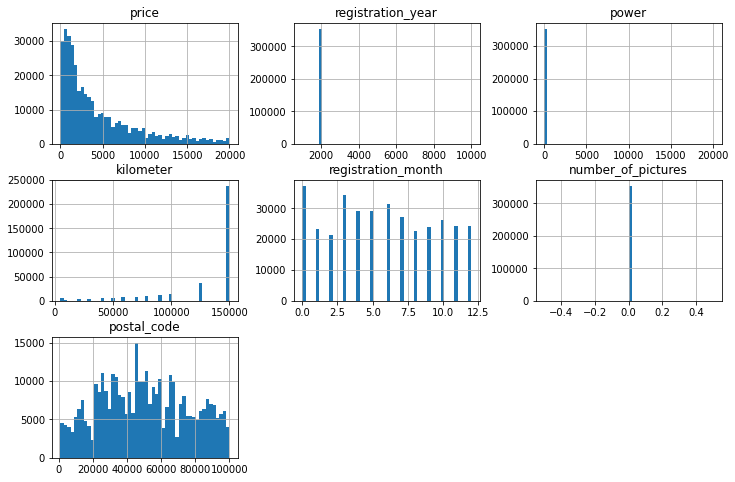

In [10]:
data.hist(bins=50, figsize=(12, 8))

Посмотрим на корреляцию количественных признаков с ценой:

In [11]:
data.drop('price', axis=1).corrwith(data.price)

registration_year     0.026916
power                 0.158872
kilometer            -0.333199
registration_month    0.110581
number_of_pictures         NaN
postal_code           0.076055
dtype: float64

Самая высокая корреляция с kilometer и power.

#### Удаление неинформативных признаков

Можно убрать кризнак 'number_of_pictures', так как все значения в колонке равны нулю:

In [12]:
data=data.drop(['number_of_pictures'], axis=1)

Можно убрать признаки postal_code и registration_year, так как они показывают низкую корреляцию с целевым признаком:

In [13]:
data=data.drop(['postal_code'], axis=1)

Теперь изучим колонки, указывающие время. Очевидно, что цена от времени выгрузки данных из датабазы и последнего повления пользователя в сети не зависит. Удалим эти колонки как неинформативные:

In [14]:
data = data.drop(['date_crawled', 'last_seen'], axis=1)

От даты создания анкеты зависимость может существовать. Переведём данные времени создания анкеты в датасете в формат datetime и разделим на год, месяц и день, чтобы проверить:

In [15]:
data['date_created_year'] = pd.to_datetime(data['date_created']).dt.year
data['date_created_month'] = pd.to_datetime(data['date_created']).dt.month
data['date_created_day'] = pd.to_datetime(data['date_created']).dt.day

Построим график зависимости от года и месяца:

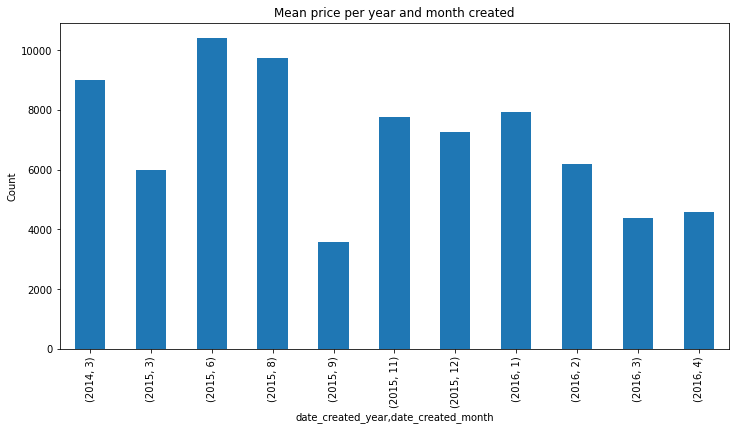

In [16]:
data.groupby(['date_created_year', 'date_created_month']).mean().price.plot.bar(
    title='Mean price per year and month created', figsize=(12,6))
plt.ylabel('Count')
plt.show()

Построим график зависимости от дня:

<AxesSubplot:title={'center':'Mean price per day created'}, xlabel='date_created_day'>

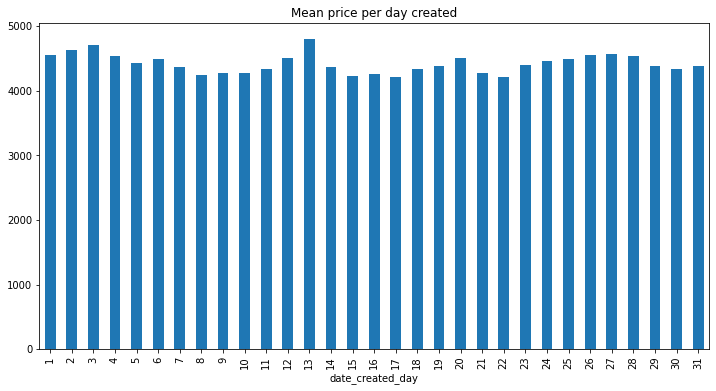

In [17]:
data.groupby(['date_created_day']).mean().price.plot.bar(title='Mean price per day created', figsize=(12,6))

Так как данные о времени создания не охватывают все месяцы начиная с 2014 года, нельзя точно сказать о зависимости цены от этих данных. При этом от дня создания зависимости цены фактически нет. Можно удалить эти признаки.

In [18]:
data = data.drop(['date_created', 'date_created_year', 'date_created_month', 'date_created_day'], axis=1)

In [19]:
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired'],
      dtype='object')

#### Registration_month

Для каждого месяца регистрации построим график средней цены:

In [20]:
reg_month = data.groupby(by='registration_month').mean().price

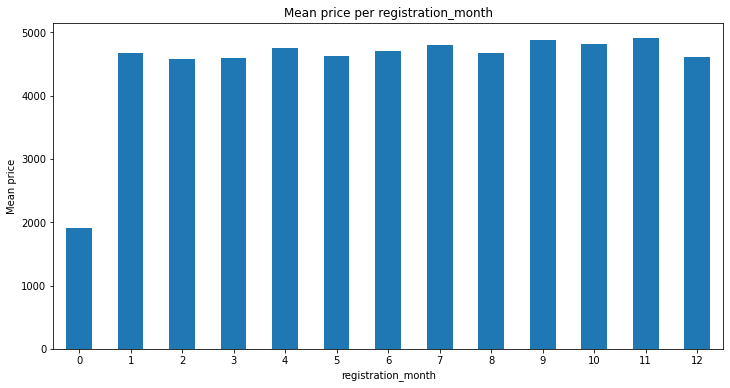

In [21]:
reg_month.plot.bar(title='Mean price per registration_month', figsize=(12,6))
plt.ylabel('Mean price')
plt.xticks(rotation=0);

Все указанные в датасете месяцы регистрации, за исключением 0, имеют примерно одинаковую среднюю цену. Так как нет месяца с порядковым номером 0, вероятно, так обозначены пропуски в этой колонке. И для таких колонок цена меньше более чем в два раза.

Вероятно, значение имеет только само по себе наличие или отсутствие данных о месяце регистрации. Поэтому заменим все номера месяца на 1. Тогда 0 будет означать отсутствие месяца, а 1 - его наличие.

In [22]:
data.registration_month = data.registration_month.replace(range(1, 13), 1)

#### Пропуски

In [23]:
data.isnull().mean() * 100

price                  0.000000
vehicle_type          10.579368
registration_year      0.000000
gearbox                5.596709
power                  0.000000
model                  5.560588
kilometer              0.000000
registration_month     0.000000
fuel_type              9.282697
brand                  0.000000
repaired              20.079070
dtype: float64

Пропуски есть только в категориальных переменных. Так как мы вряд ли можем качественно восстановить значение категорий по каким-либо другим данным, мы заполним пропуски значением 'Unknown':

In [24]:
data = data.fillna('Unknown')

#### Price

Изучим аномальные значения цены:

<AxesSubplot:title={'center':'Price boxplot'}>

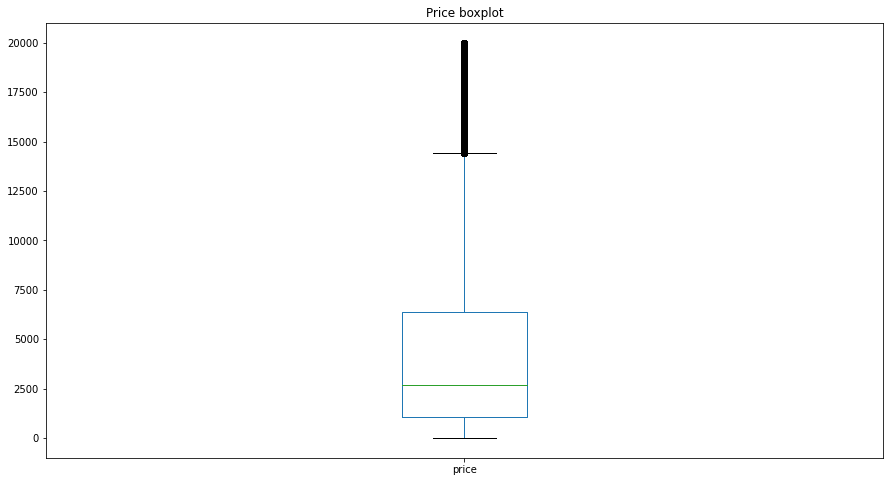

In [25]:
data.price.plot(kind='box', figsize=(15,8), title='Price boxplot')

Никаких выбивающихся из общего распределения выбросов нет. Но есть очень низкие цены:

Возьмём за минимальный порог цены 100:

In [26]:
data[data.price <= 100].price.count()

14345

In [27]:
data[data.price <= 100].price.count()/data.price.count()

0.04048040319553911

Из них с ценой 0 и 1:

In [28]:
data[(data.price <=1)].price.count()

11961

In [29]:
data[(data.price <=1)].price.count()/data.price.count()

0.03375295243094063

4% процента всех данных ценой ниже 100 , из них 3.3% с ценами 0 и 1. Вероятно, могла произойти ошибка при записи данных в базу - технический сбой, человеческий фактор или просто отутствие цены. Так как цена - таргет для обучения моделей, объекты с этими ценами бесполезны для задачи обучения. Остальные объёкты в данном диапазоне представлены в очень малом количестве, и хотя мы не можем наверняка сказать, какая цена может быть минимальной, значения таргета ниже 100 кажутся здесь лишними и неинформативными. Уберём все данные от 100 и ниже из датасета:

In [30]:
data = data[data.price >100]

#### Power

Проанализируем колонку Power:

<AxesSubplot:title={'center':'Power boxplot'}>

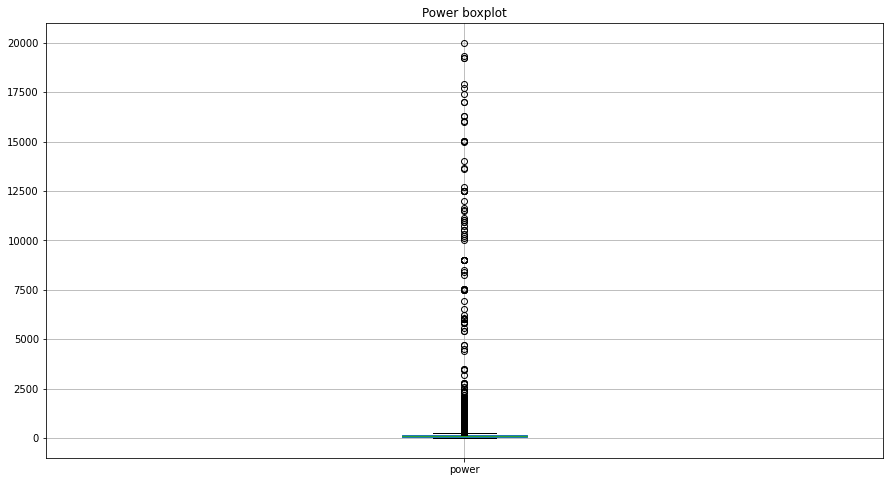

In [31]:
data.power.plot(kind='box', figsize=(15,8), title='Power boxplot', grid=True)

Здесь присутствуют аномальные значения. Для обычных автомобилей максимальная мощность автомобиля в лошадиных силах - 2028 у Dagger GT (если верить информации в доступных источниках, и не считать тяжёлые карьерные грузовики). В датасете присутствуют автомобили с мощностью выше этого порога:

In [32]:
data[data.power > 2028]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
7661,1499,small,1999,manual,7515,lupo,150000,1,petrol,volkswagen,Unknown
19092,9750,wagon,2005,auto,2729,5er,150000,1,gasoline,bmw,no
25232,10900,bus,2009,manual,10520,caddy,150000,1,gasoline,volkswagen,no
33952,3740,small,2006,manual,6920,aygo,90000,1,Unknown,toyota,no
44520,2500,convertible,1998,manual,7512,golf,150000,1,Unknown,volkswagen,Unknown
...,...,...,...,...,...,...,...,...,...,...,...
341066,449,Unknown,2016,manual,4507,corsa,150000,1,petrol,opel,no
341320,1899,other,2006,manual,7518,berlingo,125000,1,petrol,citroen,yes
346639,1300,sedan,2000,manual,12512,carisma,150000,1,petrol,mitsubishi,Unknown
348137,850,sedan,1993,auto,9012,golf,150000,0,petrol,volkswagen,Unknown


Всего таких машин 100. Мы могли бы попытаться восстановить истинные значения этих данных, но в масштабах датасета этих машин крайне мало, так что просто ограничим верхний порог значением в 2000:

In [33]:
data[data.power > 2028] = 2000

Посмотрим на колонки, где power = 0:

In [34]:
data[data.power == 0].price.count()

34653

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'registration_year'}>],
       [<AxesSubplot:title={'center':'power'}>,
        <AxesSubplot:title={'center':'kilometer'}>],
       [<AxesSubplot:title={'center':'registration_month'}>,
        <AxesSubplot:>]], dtype=object)

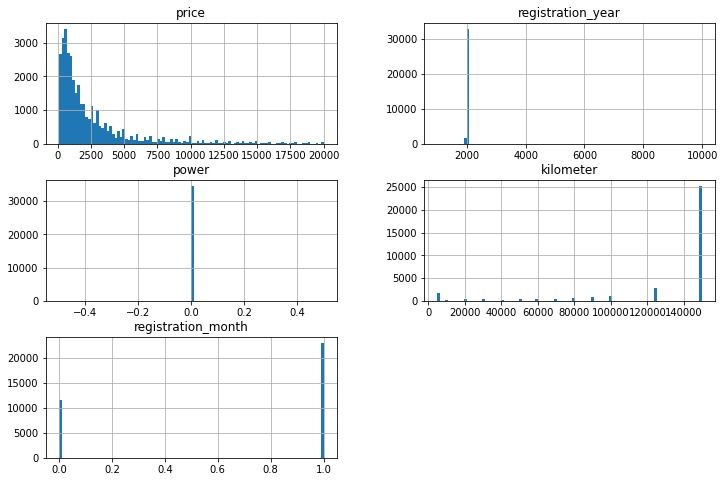

In [35]:
data[data.power == 0].hist(bins=100, figsize=(12,8))

In [36]:
data[data.power == 0].power.count()/data.power.count()

0.10191339434863421

In [37]:
data[data.power == 0].describe()

,price,registration_year,power,kilometer,registration_month
count,34653.000000,34653.000000,34653.0,34653.000000,34653.000000
mean,2518.752374,2008.062159,0.0,129502.207601,0.665484
std,3146.457146,199.677970,0.0,41207.536877,0.471828
min,101.000000,1000.000000,0.0,5000.000000,0.000000
25%,650.000000,1998.000000,0.0,125000.000000,0.000000
50%,1399.000000,2001.000000,0.0,150000.000000,1.000000
75%,3000.000000,2007.000000,0.0,150000.000000,1.000000
max,20000.000000,9999.000000,0.0,150000.000000,1.000000


10% данных имеют power равную 0. Логично, что автомобилей с мощностью 0 не бывает, так что можно сделать вывод, что так обозначены пропуски в данных. Распределение остальных количественных данных в датасете для этой категории не выглядит аномальным, поэтому оставим всё как есть.

#### Год регистрации

Посмотрим на год регистрации:

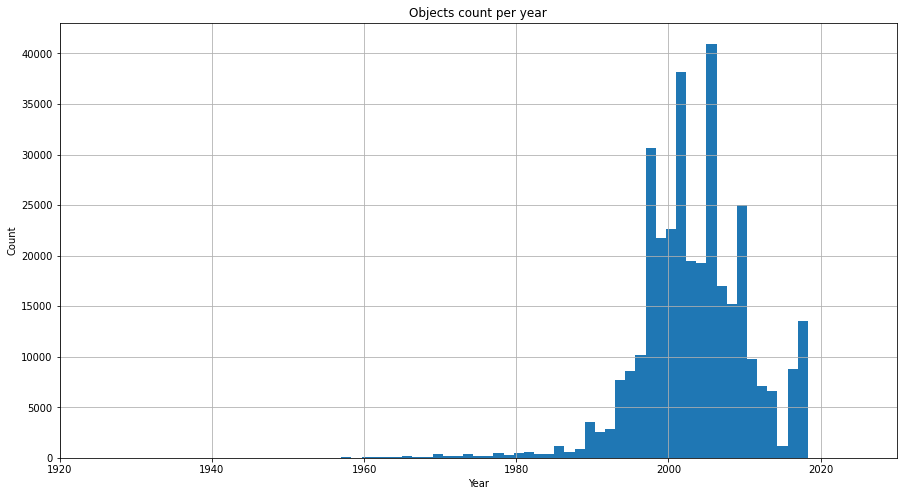

In [38]:
data.registration_year.hist(range=(1925, 2025), bins=75, figsize=(15,8))
plt.title('Objects count per year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show();

Будем считать все машины годом выпуска меньше 1960 аномальными. Выделим автомобили, выпущенные до 1960 или после года выгрузки анкет (2016):

In [39]:
data[(data.registration_year < 1960) | (data.registration_year > 2016)].registration_year.count()/data.registration_year.count()

0.041064748370703244

Всего 4% автомобилей имеют аномальные года выпуска. Можно попробовать присвоить им другие значения года, но проще удалить:

In [40]:
data = data[(data.registration_year >= 1982) & (data.registration_year <= 2016)]

In [41]:
data.registration_year.min(), data.registration_year.max()

(1982, 2016)

#### Вывод

Проведена предобработка данных датасета. Удалены неинформативные признаки pictures_count, а также колонки с датой и временем. Исключены объекты с ценой ниже 100, включая со значениями 0. Также удалены данные с аномальными значениями power и года регистрации. Заполнены пропуски в категориальных признаках значением Unknown.

Проверим, какой процент данных в итоге был исключён из датасета: 

In [42]:
(1 - (data.shape[0] / 354369)) * 100

8.964666773899522

9%. Погранично, но приемлемо.

## Обучение моделей

#### Разделение выборок

Разделим выборки на train и test в соотношении 3:1

In [43]:
train_features, test_features, train_target, test_target = train_test_split(
    data.drop('price', axis=1), data.price, test_size=0.25, random_state=12345)

Проверим размерности выборок:

In [44]:
train_features.shape

(241950, 10)

In [45]:
test_features.shape

(80651, 10)

Всё верно

#### Ohe

Закодируем категориальные признаки с помощью One-Hot Encoding, при этом избегая dummy-ловушки.

In [46]:
categorical_features=['vehicle_type', 'gearbox', 'fuel_type', 'repaired']

In [47]:
encoder = OneHotEncoder(drop='first', sparse=False)

In [48]:
train_features_cat = train_features[categorical_features].astype(str)
train_features_cat

In [49]:
test_features_cat = test_features[categorical_features].astype(str)
test_features_cat

In [50]:
encoder.fit(train_features_cat)

In [51]:
train_transformed = encoder.transform(train_features_cat)
train_features_encoded = pd.DataFrame(train_transformed, columns=encoder.get_feature_names(), index=train_features_cat.index)
train_features = train_features.join(train_features_encoded).drop(categorical_features, axis=1)

In [52]:
test_transformed = encoder.transform(test_features_cat)
test_features_encoded = pd.DataFrame(test_transformed, columns=encoder.get_feature_names(), index=test_features_cat.index)
test_features = test_features.join(test_features_encoded).drop(categorical_features, axis=1)

In [53]:
train_features

#### MEstimateEncoder

Часть категориальных данных представлена очень большим объёмом категорий, что при кодировании OHE может привести к проблемам. Воспользуемся MEstimateEncoder из библиотеки scikit-learn и закодируем категории через средние значения таргета

In [54]:
big_cat_features = ['brand', 'model']

In [55]:
es_encoder = MEstimateEncoder()

In [56]:
es_encoder.fit(train_features[big_cat_features], train_target)

In [57]:
train_features.loc[:,big_cat_features] = es_encoder.transform(train_features[big_cat_features], train_target)
train_features

In [58]:
test_features.loc[:,big_cat_features] = es_encoder.transform(test_features[big_cat_features], test_target)
test_features

#### Scaling

Отскейлим данные:

In [59]:
scaler = StandardScaler()
columns = train_features.columns

In [60]:
scaler.fit(train_features)
train_features = pd.DataFrame(scaler.transform(train_features), columns=train_features.columns, index=train_features.index)
test_features = pd.DataFrame(scaler.transform(test_features), columns=test_features.columns, index=test_features.index)

#### Boosting

Обучим LGBMRegressor из библиотеки LightGBM, подобрав к нему параметры с помощью GridSearchCV с метрикой rmse:

In [61]:
params = {
    'metric':['rmse'], 
    'num_iterations':[25, 50, 100], 
    'boosting':['gbdt'], 
    'num_leaves':[12, 22, 31, 45], 
    'max_depth':[-1, 2, 4, 7]
         }

In [62]:
estimator = lgb.LGBMRegressor(objective='regression', metric='rmse', random_state=12345)

In [63]:
model = GridSearchCV(estimator = estimator, param_grid=params, cv=5, scoring='neg_root_mean_squared_error')

In [64]:
%%time
model.fit(train_features, train_target)

Лучшие параметры и лучшая модель:

In [65]:
model.best_params_

In [66]:
model.best_estimator_

In [67]:
best_model = lgb.LGBMRegressor(objective='regression', metric='rmse', num_iterations=100, num_leaves=45, random_state=12345)

In [68]:
%%time
best_model.fit(train_features, train_target)

Проверим качество модели на тестовых данных

In [69]:
%%time
predicted = best_model.predict(test_features)

In [70]:
metric = np.sqrt(mean_squared_error(test_target, predicted))
metric

#### Random Forest

Обучим другую модель, чтобы сравнить качество с бустингом:

In [71]:
forest_estimator = RandomForestRegressor(max_depth=2, n_estimators=100, min_samples_split=4, random_state=12345)

In [72]:
%%time
forest_estimator.fit(train_features, train_target)

In [73]:
%%time
forest_predicted = forest_estimator.predict(test_features)

In [74]:
forest_metric = np.sqrt(mean_squared_error(test_target, forest_predicted))
forest_metric

Случайный лес выдаёт метрику хуже в два раза.

## Анализ моделей

При сравнении random_forest и LGBMRegressor метрика rmse лучше у бустинга (1592 против 3105, почти в два раза), к тому же, только она преодолевает порог качества в 2500. Скорость тренировки случайного леса в несколько раз ниже бустинга. Скорость предсказания леса чуть выше, чем у бустинга, но скорость обучения бустинга на порядок быстрее. В совокупности, исходя из скорости тренировки, скорости предсказания и качества предсказания бустинг существенно опережает случайный лес. Бустинг является более эффективной моделью.

## Общий вывод


Изучены данные об объявлениях о продаже автомобилей. Нужно было обучить модель, предсказывающую цену. Качество модели должно было быть проверено с помощью rmse и не быть выше 2500. После проведения предобработки данных, удаления аномалий и неинформативных признаков была обучена модель LGBMRegressor. На тренировочном датасете с параметрами модели = {boosting='gbdt', metric='rmse', num_iterations=100, num_leaves=45, objective='regression', random_state=12345}, подобранными с помощью GridSearchCV, метрика качества rmse оказалась равна 1592. Для сравнения также был обучен случайный лес с параметрами {max_depth=2, n_estimators=100, min_samples_split=4, random_state=12345}. Случайный лес показал себя хуже с точки зрения качества со значением rmse 3105, что не попадает в необходимые границы качества. Также случайный лес на порядок медленее обучается.

Исходя из проведённой работы, градиентный бустинг является существенно более эффективной моделью.